In [1]:
from astropy.io import fits as pyfits
import numpy as np
import matplotlib.pyplot as pl
import glob
import os
from tqdm import tqdm
from scipy.ndimage.measurements import label
%matplotlib inline

In [16]:
def getFlux(plot=True):
    """Return a (random) stitching of the postage stamps for C9."""
    ntime = 1290
    nrows = 250
    ncols = 250
    ntries = 500
    satlim = 150000
    flux = np.zeros((ntime, nrows, ncols)) * np.nan
    files = glob.glob('data/c9/*/*/*.fits.gz')
    for file in tqdm(files):
        with pyfits.open(file) as f:
            time = f[1].data['TIME']
            ftmp = f[1].data['FLUX']
            # Reject saturated stars
            if np.nanmax(ftmp) > satlim:
                continue
            for i in range(ntries):
                row = np.random.randint(0, nrows - ftmp.shape[1])
                col = np.random.randint(0, ncols - ftmp.shape[2])
                if np.all(np.isnan(flux[0, row:row + ftmp.shape[1], col:col + ftmp.shape[2]])):
                    flux[:, row:row + ftmp.shape[1], col:col + ftmp.shape[2]] = ftmp
                    break
            if i == ntries - 1:
                raise Exception("Unable to place image.")
    if plot:
        fig = pl.figure(figsize=(14, 14))
        pl.imshow(flux[0], vmax=1e4);
    return time, flux

100%|██████████| 187/187 [00:14<00:00, 13.18it/s]


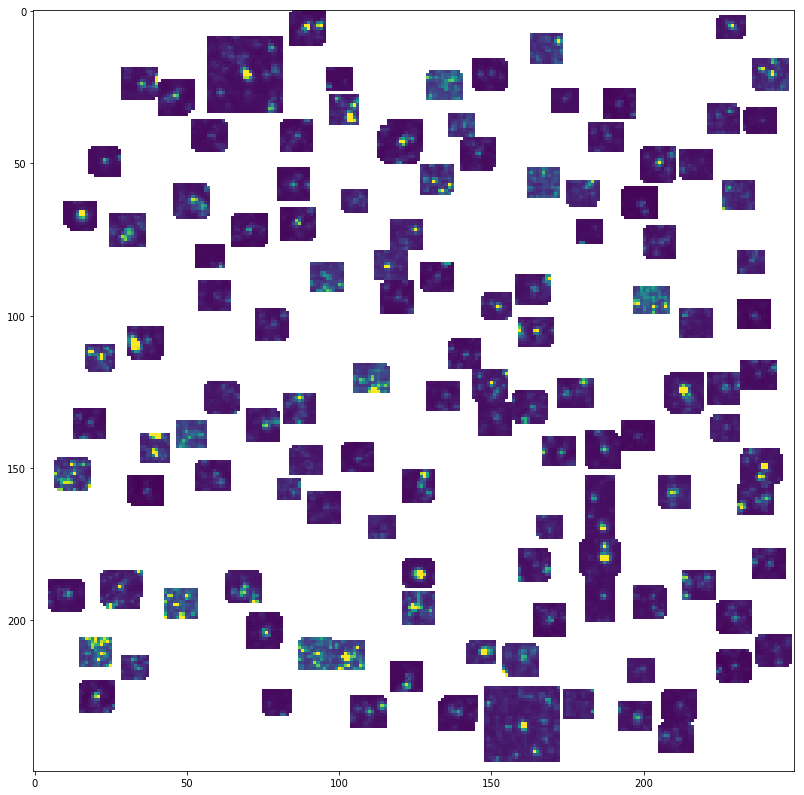

In [17]:
# Get the flux
time, flux = getFlux(True)

/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


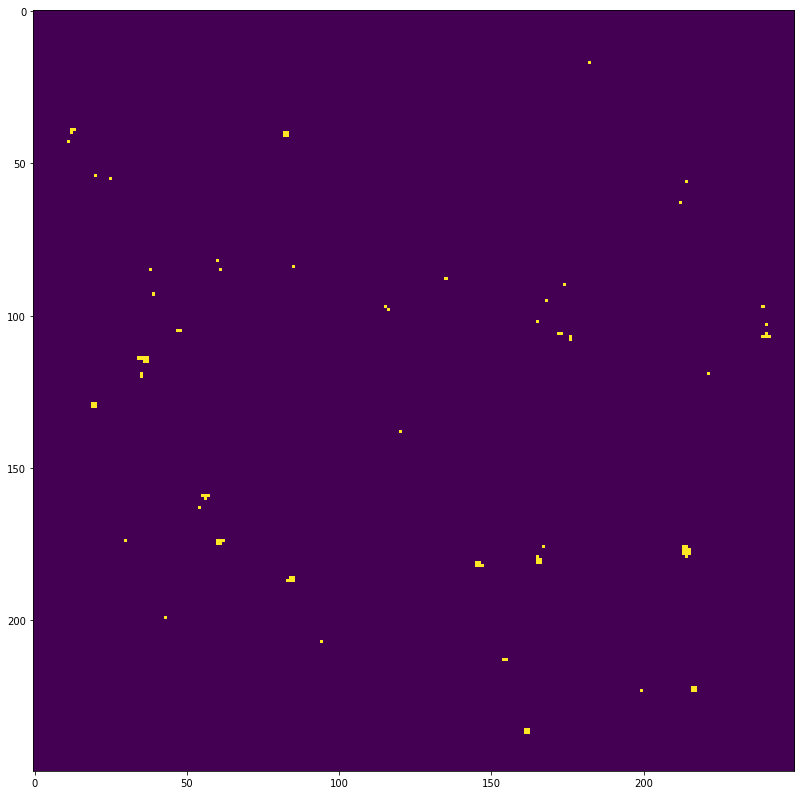

In [5]:
# Label sources
img = np.nanmedian(flux, axis=0)
mu = np.nanmedian(img)
sigma = np.sqrt(np.nanmedian((img-mu)**2))
m = (img - mu) > 40*sigma
m &= np.isfinite(img)
labels, nstar = label(m)
fig = pl.figure(figsize=(14, 14))
pl.imshow(m);

In [11]:
# Get our regressors
lcs = np.empty((nstar-1, len(flux)), dtype=np.float32)
for star in range(nstar-1):
    lcs[star] = np.sum(flux[:, labels == star+1], axis=1)
lcs = lcs / np.median(lcs, axis=-1)[:, None] - 1

(240, 229)

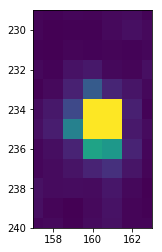

In [24]:
# This is our target
pl.imshow(flux[0], vmax=1e4)
pl.xlim(157, 163)
pl.ylim(240, 229)

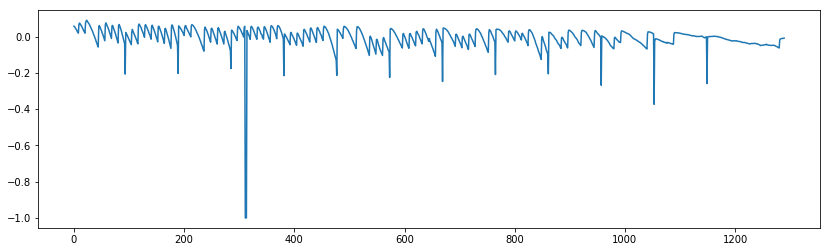

In [32]:
target = flux[:, 157:164, 229:241]
target_lc = np.nansum(target, axis=(1, 2))
target_lc = target_lc / np.nanmedian(target_lc) - 1
fig = pl.figure(figsize=(14, 4))
pl.plot(target_lc);